In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


Found 5 CSV files


Loading datasets: 100%|██████████| 5/5 [00:00<00:00, 275.82it/s]


Dataset sizes:
Total samples: 5938
Train: 4156 (70.0%)
Validation: 890 (15.0%)
Test: 892 (15.0%)

Visualizing sample datapoints from training set...


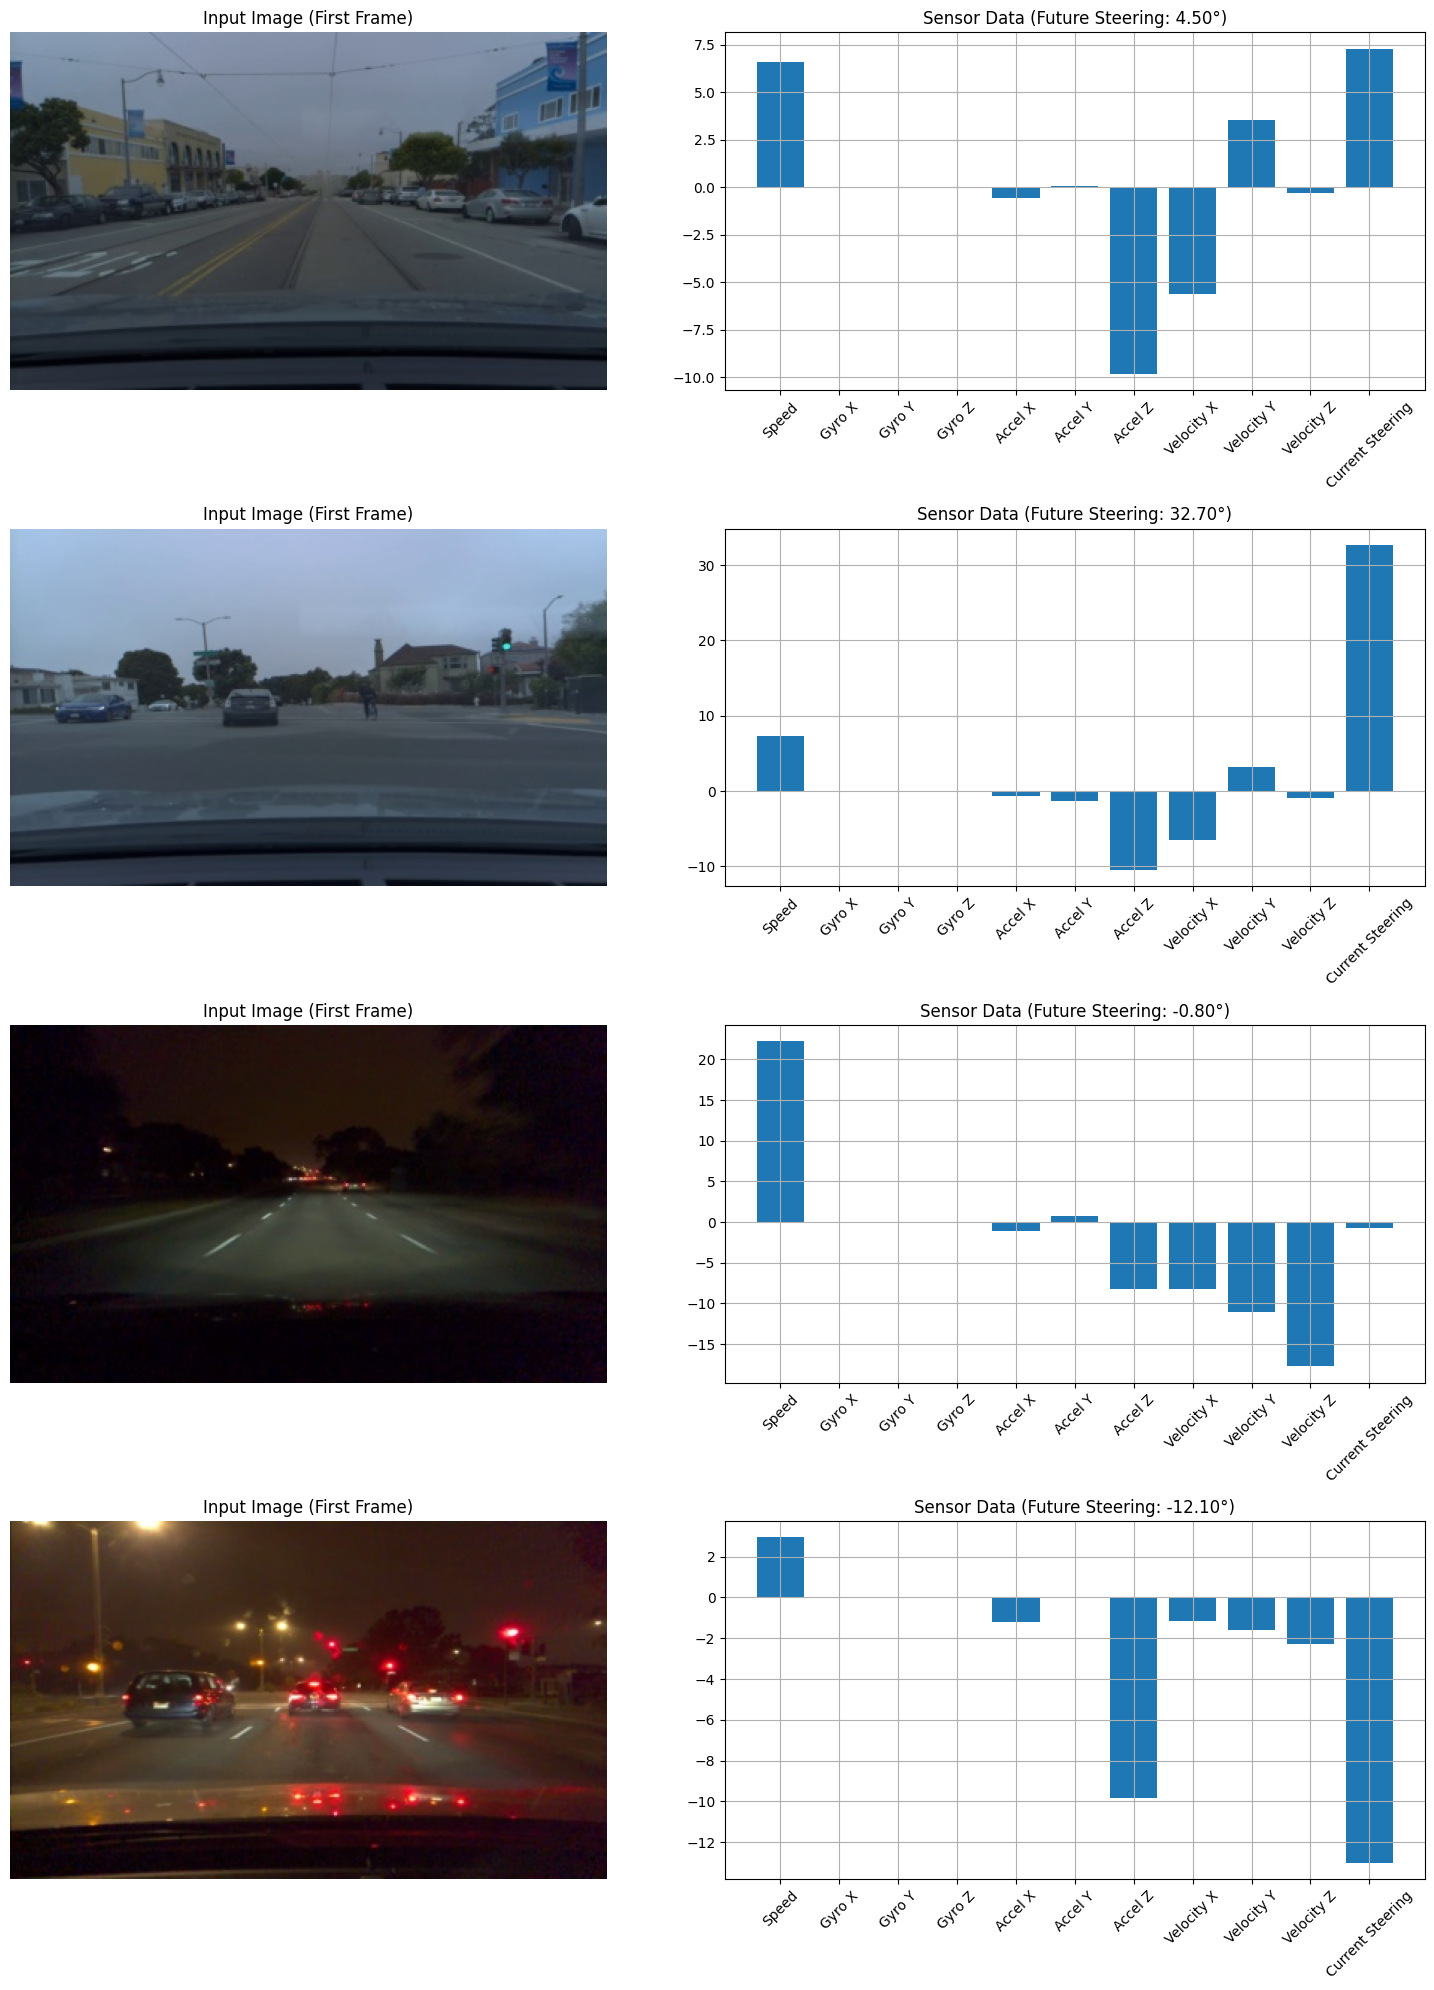

In [2]:
import glob
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define base directory paths
DATA_DIR = 'data_synced'  # Directory containing processed CSV files and frame folders

class SequentialDrivingDataset(Dataset):
    def __init__(self, csv_file, sequence_length=10, transform=None):
        self.sequence_length = sequence_length
        self.data = pd.read_csv(csv_file)
        
        # Get frames directory path from CSV filename
        base_dir = os.path.dirname(csv_file)
        filename = os.path.basename(csv_file)
        self.frames_dir = os.path.join(base_dir, f"{filename[:-4]}_frames")
        
        # Verify frames directory exists
        if not os.path.exists(self.frames_dir):
            raise FileNotFoundError(f"Frames directory not found: {self.frames_dir}")
        
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])
        
        # Create sequences
        self.sequences = []
        total_frames = len(self.data)
        for i in range(total_frames - sequence_length + 1):
            self.sequences.append(i)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence_start = self.sequences[idx]
        
        # Initialize sequence containers
        image_sequence = []
        sensor_sequence = []
        target_sequence = []
        
        # Build sequence
        for i in range(self.sequence_length):
            frame_idx = sequence_start + i
            row = self.data.iloc[frame_idx]
            
            # Load image
            frame_path = os.path.join(self.frames_dir, f"{int(row['frame_idx'])}.jpg")
            frame = Image.open(frame_path).convert('RGB')
            if self.transform:
                frame = self.transform(frame)
            image_sequence.append(frame)
            
            # Get sensor data
            sensor_data = torch.tensor([
                float(row['speed'].strip('[]') if isinstance(row['speed'], str) else row['speed']),
                row['gyro_x'], row['gyro_y'], row['gyro_z'],
                row['accel_x'], row['accel_y'], row['accel_z'],
                row['velocity_x'], row['velocity_y'], row['velocity_z'],
                row['current_steering'],
            ], dtype=torch.float32)
            sensor_sequence.append(sensor_data)
            
            # Get target (future steering angle)
            target = torch.tensor(row['future_steering'], dtype=torch.float32)
            target_sequence.append(target)
        
        # Stack sequences
        image_sequence = torch.stack(image_sequence)  # [T, C, H, W]
        sensor_sequence = torch.stack(sensor_sequence)  # [T, 11]
        target_sequence = torch.stack(target_sequence)  # [T]
        
        return image_sequence, sensor_sequence, target_sequence
    

def visualize_sample_datapoints(dataset, num_samples=4):
    """
    Visualize a few sample datapoints from the dataset to verify format
    Shows the first frame from each sequence
    """
    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        # Get a random sample
        idx = np.random.randint(len(dataset))
        image_sequence, sensor_sequence, target_sequence = dataset[idx]
        
        # Take first frame and sensor data from the sequence
        image = image_sequence[0]  # First frame
        sensor_data = sensor_sequence[0]  # First sensor reading
        target = target_sequence[0]  # First target value
        
        # Convert image tensor back to displayable format
        img = image.numpy().transpose(1, 2, 0)
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # Plot image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Input Image (First Frame)')
        axes[i, 0].axis('off')
        
        # Create sensor data visualization
        sensor_labels = [
            'Speed', 
            'Gyro X', 'Gyro Y', 'Gyro Z',
            'Accel X', 'Accel Y', 'Accel Z',
            'Velocity X', 'Velocity Y', 'Velocity Z',
            'Current Steering'
        ]
        
        # Plot sensor data as a bar chart
        axes[i, 1].bar(sensor_labels, sensor_data.numpy())
        axes[i, 1].set_title(f'Sensor Data (Future Steering: {target:.2f}°)')
        axes[i, 1].tick_params(axis='x', rotation=45)
        axes[i, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
# Get list of all CSV files in data_synced
csv_files = [f for f in glob.glob('data_synced/*.csv') if 'combined_dataset.csv' not in f]
print(f"Found {len(csv_files)} CSV files")

# Create datasets for each segment
datasets = []
for csv_file in tqdm(csv_files, desc="Loading datasets"):
    try:
        dataset = SequentialDrivingDataset(csv_file)
        datasets.append(dataset)
    except Exception as e:
        print(f"Error loading {csv_file}: {str(e)}")
        continue

if not datasets:
    raise RuntimeError("No datasets were successfully loaded!")

# Combine all datasets
full_dataset = ConcatDataset(datasets)
total_size = len(full_dataset)

# Split dataset into train, validation, and test sets (70%, 15%, 15%)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

print(f"\nDataset sizes:")
print(f"Total samples: {total_size}")
print(f"Train: {len(train_dataset)} ({len(train_dataset)/total_size*100:.1f}%)")
print(f"Validation: {len(val_dataset)} ({len(val_dataset)/total_size*100:.1f}%)")
print(f"Test: {len(test_dataset)} ({len(test_dataset)/total_size*100:.1f}%)")

# Create data loaders with no workers for simplicity
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

# Visualize some samples to verify data format
print("\nVisualizing sample datapoints from training set...")
visualize_sample_datapoints(train_dataset)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

class ResBlock(nn.Module):
    """
    Basic ResNet block with optional downsampling.
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        
        # First convolution block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Second convolution block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection (identity or 1x1 conv)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):  # Add missing forward method
        identity = x
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        out += self.shortcut(identity)
        out = F.relu(out)
        
        return out

class SteeringRNN(nn.Module):
    """
    RNN model for predicting steering angles with proper temporal processing.
    """
    def __init__(self, sequence_length=10, hidden_size=64):
        super(SteeringRNN, self).__init__()
        self.sequence_length = sequence_length
        self.hidden_size = hidden_size
        self.sensor_input_size = 11

        # CNN layers for visual feature extraction (same as before)
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(24),

            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(36),

            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(48),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(48, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

        # Calculate CNN output size
        with torch.no_grad():
            dummy_img = torch.zeros(1, 3, 240, 400)
            dummy_features = self.conv_layers(dummy_img)
            self.cnn_output_size = dummy_features.view(-1).shape[0]
            print(f"CNN output size per frame: {self.cnn_output_size}")

        # Sensor processing network
        self.sensor_net = nn.Sequential(
            nn.Linear(self.sensor_input_size, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2)
        )

        # Feature fusion layer to combine CNN and sensor features
        self.fusion_layer = nn.Sequential(
            nn.Linear(self.cnn_output_size + 64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2)
        )

        # RNN layer - takes fused features as input
        self.rnn = nn.LSTM(
            input_size=128,  # Size of fused features
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )

        # Final prediction layer
        self.final = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )

    def forward(self, image_sequence, sensor_sequence):
        """
        Forward pass with parallel CNN processing.
        Args:
            image_sequence: [batch_size, sequence_length, channels, height, width]
            sensor_sequence: [batch_size, sequence_length, sensor_features]
        Returns:
            predictions: [batch_size, sequence_length, 1]
        """
        batch_size = image_sequence.size(0)
        sequence_length = image_sequence.size(1)
        device = image_sequence.device

        # Initialize LSTM hidden state
        h0 = torch.zeros(2, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(2, batch_size, self.hidden_size).to(device)
        hidden = (h0, c0)

        # Process all frames through CNN at once
        # Reshape from [B, T, C, H, W] to [B*T, C, H, W]
        images_reshaped = image_sequence.view(-1, 3, 240, 400)
        visual_features = self.conv_layers(images_reshaped)
        visual_features = visual_features.view(batch_size, sequence_length, -1)

        # Process all sensor data at once
        sensor_features = self.sensor_net(sensor_sequence.view(-1, self.sensor_input_size))
        sensor_features = sensor_features.view(batch_size, sequence_length, -1)

        # Fuse features for all timesteps at once
        combined = torch.cat([visual_features, sensor_features], dim=2)
        fused_features = self.fusion_layer(combined.view(-1, self.cnn_output_size + 64))
        fused_features = fused_features.view(batch_size, sequence_length, -1)

        # Process through RNN
        rnn_out, _ = self.rnn(fused_features, hidden)

        # Make predictions for all timesteps
        predictions = self.final(rnn_out.reshape(-1, self.hidden_size))
        predictions = predictions.view(batch_size, sequence_length, 1)

        return predictions

    def init_hidden(self, batch_size, device):
        """Initialize hidden state"""
        h0 = torch.zeros(2, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(2, batch_size, self.hidden_size).to(device)
        return (h0, c0)

In [4]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    """
    Train the model with early stopping.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"\nGPU Information:")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"Current device: {torch.cuda.current_device()}")
        print(f"Device name: {torch.cuda.get_device_name()}")
        print(f"Device memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    model.to(device)
    print(f"Training on {device}")

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for image_sequence, sensor_sequence, target_sequence in pbar:
                # Move data to device
                image_sequence = image_sequence.to(device)  # [B, T, C, H, W]
                sensor_sequence = sensor_sequence.to(device)  # [B, T, 11]
                # Reshape target to match model output
                target_sequence = target_sequence.to(device).unsqueeze(-1)  # [B, T, 1]
                
                # Forward pass
                optimizer.zero_grad()
                outputs = model(image_sequence, sensor_sequence)  # [B, T, 1]
                
                # Compute loss
                loss = criterion(outputs, target_sequence)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * image_sequence.size(0)
                pbar.set_postfix({'loss': loss.item()})

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0

        with torch.no_grad():
            for image_sequence, sensor_sequence, target_sequence in val_loader:
                image_sequence = image_sequence.to(device)
                sensor_sequence = sensor_sequence.to(device)
                target_sequence = target_sequence.to(device).unsqueeze(-1)  # Add dimension here too
                
                outputs = model(image_sequence, sensor_sequence)
                loss = criterion(outputs, target_sequence)
                running_loss += loss.item() * image_sequence.size(0)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f'Epoch {epoch+1}: Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Load best model
    if best_model is not None:
        model.load_state_dict(best_model)

    return model, train_losses, val_losses

In [5]:
def test_model(model, test_loader):
    """
    Test the model with steering-specific metrics for future steering angle prediction.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for image_sequence, sensor_sequence, target_sequence in test_loader:
            image_sequence = image_sequence.to(device)
            sensor_sequence = sensor_sequence.to(device)
            target_sequence = target_sequence.to(device)
            
            outputs = model(image_sequence, sensor_sequence)
            
            # Flatten sequences for metrics
            all_preds.extend(outputs.cpu().numpy().flatten())
            all_targets.extend(target_sequence.cpu().numpy().flatten())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Calculate metrics
    mse = np.mean((all_preds - all_targets) ** 2)
    mae = np.mean(np.abs(all_preds - all_targets))
    within_1_deg = np.mean(np.abs(all_preds - all_targets) < 1.0) * 100
    within_3_deg = np.mean(np.abs(all_preds - all_targets) < 3.0) * 100
    within_5_deg = np.mean(np.abs(all_preds - all_targets) < 5.0) * 100

    print("\nTest Results (Predicting Steering Angle at t+200ms):")
    print(f"MSE: {mse:.4f} degrees²")
    print(f"MAE: {mae:.4f} degrees")
    print(f"Predictions within 1°: {within_1_deg:.1f}%")
    print(f"Predictions within 3°: {within_3_deg:.1f}%")
    print(f"Predictions within 5°: {within_5_deg:.1f}%")

    # Visualizations
    plt.figure(figsize=(15, 5))

    # Prediction vs Ground Truth
    plt.subplot(1, 2, 1)
    plt.plot(all_targets[:100], label='Future Ground Truth')
    plt.plot(all_preds[:100], label='Predicted Future')
    plt.xlabel('Sample')
    plt.ylabel('Steering Angle (degrees)')
    plt.title('Predicted vs Actual Future Steering Angles')
    plt.legend()

    # Correlation plot
    plt.subplot(1, 2, 2)
    plt.scatter(all_targets, all_preds, alpha=0.1)
    plt.plot([-45, 45], [-45, 45], 'r--')
    plt.xlabel('Actual Future Steering Angle (degrees)')
    plt.ylabel('Predicted Future Steering Angle (degrees)')
    plt.title('Prediction Correlation (t+200ms)')

    plt.tight_layout()
    plt.show()

CNN output size per frame: 1536

GPU Information:
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4090
Device memory: 25.76 GB
Training on cuda:0


Epoch 1/50: 100%|██████████| 130/130 [01:05<00:00,  2.00it/s, loss=5.92]


Epoch 1: Train Loss: 20.5664, Val Loss: 5.7091


Epoch 2/50: 100%|██████████| 130/130 [00:46<00:00,  2.81it/s, loss=5.38]


Epoch 2: Train Loss: 7.9886, Val Loss: 2.6136


Epoch 3/50: 100%|██████████| 130/130 [00:45<00:00,  2.87it/s, loss=12.3]


Epoch 3: Train Loss: 6.9525, Val Loss: 2.0797


Epoch 4/50: 100%|██████████| 130/130 [00:45<00:00,  2.87it/s, loss=3.86]


Epoch 4: Train Loss: 5.9142, Val Loss: 1.3736


Epoch 5/50: 100%|██████████| 130/130 [00:44<00:00,  2.90it/s, loss=5.14]


Epoch 5: Train Loss: 5.6391, Val Loss: 1.6848


Epoch 6/50: 100%|██████████| 130/130 [00:45<00:00,  2.87it/s, loss=2.02]


Epoch 6: Train Loss: 4.6773, Val Loss: 0.9641


Epoch 7/50: 100%|██████████| 130/130 [00:44<00:00,  2.89it/s, loss=3.11]


Epoch 7: Train Loss: 4.4176, Val Loss: 0.7815


Epoch 8/50: 100%|██████████| 130/130 [00:45<00:00,  2.88it/s, loss=1.55]


Epoch 8: Train Loss: 3.7496, Val Loss: 0.6513


Epoch 9/50: 100%|██████████| 130/130 [00:45<00:00,  2.86it/s, loss=5.17]


Epoch 9: Train Loss: 3.6478, Val Loss: 0.7666


Epoch 10/50: 100%|██████████| 130/130 [00:44<00:00,  2.89it/s, loss=1.19]


Epoch 10: Train Loss: 3.7480, Val Loss: 0.6017


Epoch 11/50: 100%|██████████| 130/130 [00:44<00:00,  2.90it/s, loss=1.57]


Epoch 11: Train Loss: 3.7068, Val Loss: 0.5603


Epoch 12/50: 100%|██████████| 130/130 [00:45<00:00,  2.89it/s, loss=2.62]


Epoch 12: Train Loss: 3.4426, Val Loss: 0.7580


Epoch 13/50: 100%|██████████| 130/130 [00:44<00:00,  2.89it/s, loss=10.2]


Epoch 13: Train Loss: 3.2263, Val Loss: 0.9857


Epoch 14/50: 100%|██████████| 130/130 [00:44<00:00,  2.89it/s, loss=1.51]


Epoch 14: Train Loss: 3.3118, Val Loss: 0.5205


Epoch 15/50: 100%|██████████| 130/130 [00:44<00:00,  2.92it/s, loss=2.16]


Epoch 15: Train Loss: 3.5277, Val Loss: 1.6269


Epoch 16/50: 100%|██████████| 130/130 [00:44<00:00,  2.91it/s, loss=2.14]


Epoch 16: Train Loss: 2.8253, Val Loss: 0.6162


Epoch 17/50: 100%|██████████| 130/130 [00:45<00:00,  2.86it/s, loss=1.86]


Epoch 17: Train Loss: 2.8205, Val Loss: 0.7301


Epoch 18/50: 100%|██████████| 130/130 [00:44<00:00,  2.91it/s, loss=1.69]


Epoch 18: Train Loss: 3.1640, Val Loss: 0.5623


Epoch 19/50: 100%|██████████| 130/130 [00:47<00:00,  2.73it/s, loss=1.36] 


Epoch 19: Train Loss: 3.3356, Val Loss: 0.6448


Epoch 20/50: 100%|██████████| 130/130 [00:44<00:00,  2.90it/s, loss=1.62] 


Epoch 20: Train Loss: 2.4807, Val Loss: 0.3740


Epoch 21/50: 100%|██████████| 130/130 [00:45<00:00,  2.83it/s, loss=1.82]


Epoch 21: Train Loss: 2.6405, Val Loss: 0.8578


Epoch 22/50: 100%|██████████| 130/130 [00:45<00:00,  2.85it/s, loss=1.22]


Epoch 22: Train Loss: 2.8503, Val Loss: 0.7040


Epoch 23/50: 100%|██████████| 130/130 [00:44<00:00,  2.90it/s, loss=1.31]


Epoch 23: Train Loss: 2.9320, Val Loss: 0.5147


Epoch 24/50: 100%|██████████| 130/130 [00:45<00:00,  2.87it/s, loss=2.38]


Epoch 24: Train Loss: 2.9221, Val Loss: 0.4524


Epoch 25/50: 100%|██████████| 130/130 [00:45<00:00,  2.84it/s, loss=1.99]


Epoch 25: Train Loss: 2.8160, Val Loss: 0.3417


Epoch 26/50: 100%|██████████| 130/130 [00:45<00:00,  2.88it/s, loss=8.23] 


Epoch 26: Train Loss: 2.8399, Val Loss: 0.4887


Epoch 27/50: 100%|██████████| 130/130 [00:44<00:00,  2.90it/s, loss=4.29] 


Epoch 27: Train Loss: 3.2426, Val Loss: 0.7718


Epoch 28/50: 100%|██████████| 130/130 [00:46<00:00,  2.80it/s, loss=1.6] 


Epoch 28: Train Loss: 3.1061, Val Loss: 0.3570


Epoch 29/50: 100%|██████████| 130/130 [00:44<00:00,  2.90it/s, loss=1.08] 


Epoch 29: Train Loss: 2.4879, Val Loss: 0.2684


Epoch 30/50: 100%|██████████| 130/130 [00:45<00:00,  2.89it/s, loss=1.1] 


Epoch 30: Train Loss: 2.9281, Val Loss: 0.3987


Epoch 31/50: 100%|██████████| 130/130 [00:45<00:00,  2.88it/s, loss=6.16] 


Epoch 31: Train Loss: 3.0874, Val Loss: 0.2258


Epoch 32/50: 100%|██████████| 130/130 [00:45<00:00,  2.86it/s, loss=4.92]


Epoch 32: Train Loss: 2.8785, Val Loss: 0.3802


Epoch 33/50: 100%|██████████| 130/130 [00:44<00:00,  2.89it/s, loss=7.67] 


Epoch 33: Train Loss: 3.0794, Val Loss: 0.8427


Epoch 34/50: 100%|██████████| 130/130 [00:45<00:00,  2.89it/s, loss=1.8] 


Epoch 34: Train Loss: 2.9015, Val Loss: 0.3455


Epoch 35/50: 100%|██████████| 130/130 [00:45<00:00,  2.87it/s, loss=1.55] 


Epoch 35: Train Loss: 2.6360, Val Loss: 0.5192


Epoch 36/50: 100%|██████████| 130/130 [00:45<00:00,  2.89it/s, loss=4.61] 


Epoch 36: Train Loss: 3.2515, Val Loss: 0.3064


Epoch 37/50: 100%|██████████| 130/130 [00:44<00:00,  2.90it/s, loss=1.23] 


Epoch 37: Train Loss: 2.3099, Val Loss: 0.2726


Epoch 38/50: 100%|██████████| 130/130 [00:45<00:00,  2.88it/s, loss=3.76] 


Epoch 38: Train Loss: 2.7909, Val Loss: 0.4215


Epoch 39/50: 100%|██████████| 130/130 [00:44<00:00,  2.90it/s, loss=1.59] 


Epoch 39: Train Loss: 2.6395, Val Loss: 0.3016
Early stopping triggered at epoch 39

Model saved to 'v4_RNN.pth'

Testing the model...

Test Results (Predicting Steering Angle at t+200ms):
MSE: 0.3212 degrees²
MAE: 0.3979 degrees
Predictions within 1°: 94.2%
Predictions within 3°: 99.7%
Predictions within 5°: 100.0%


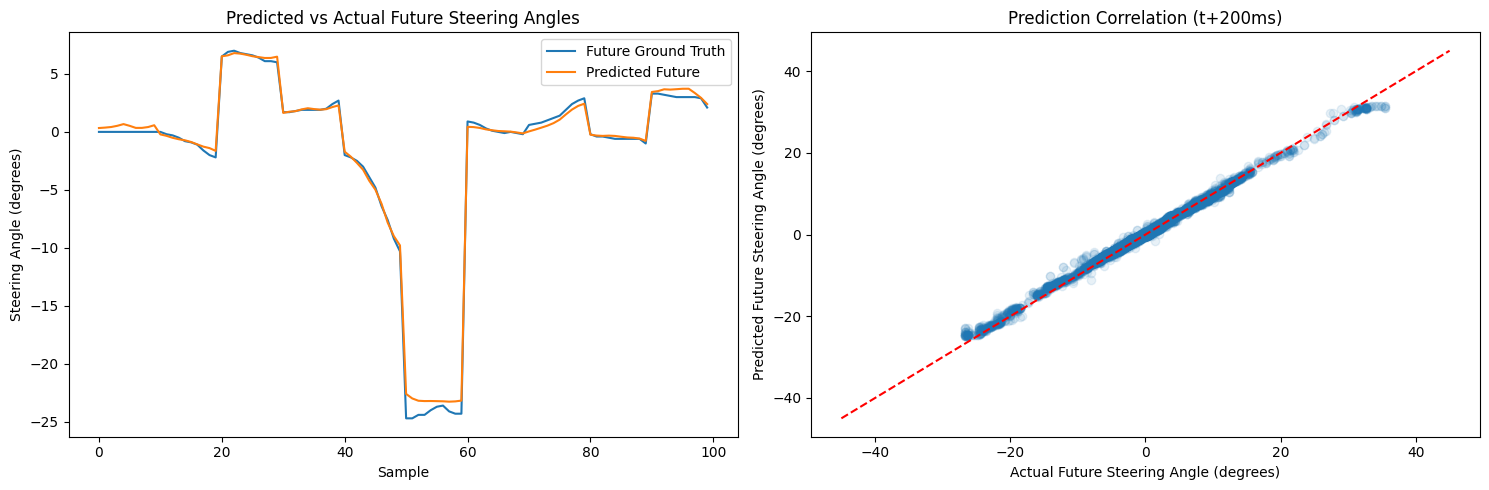


Visualizing some predictions...


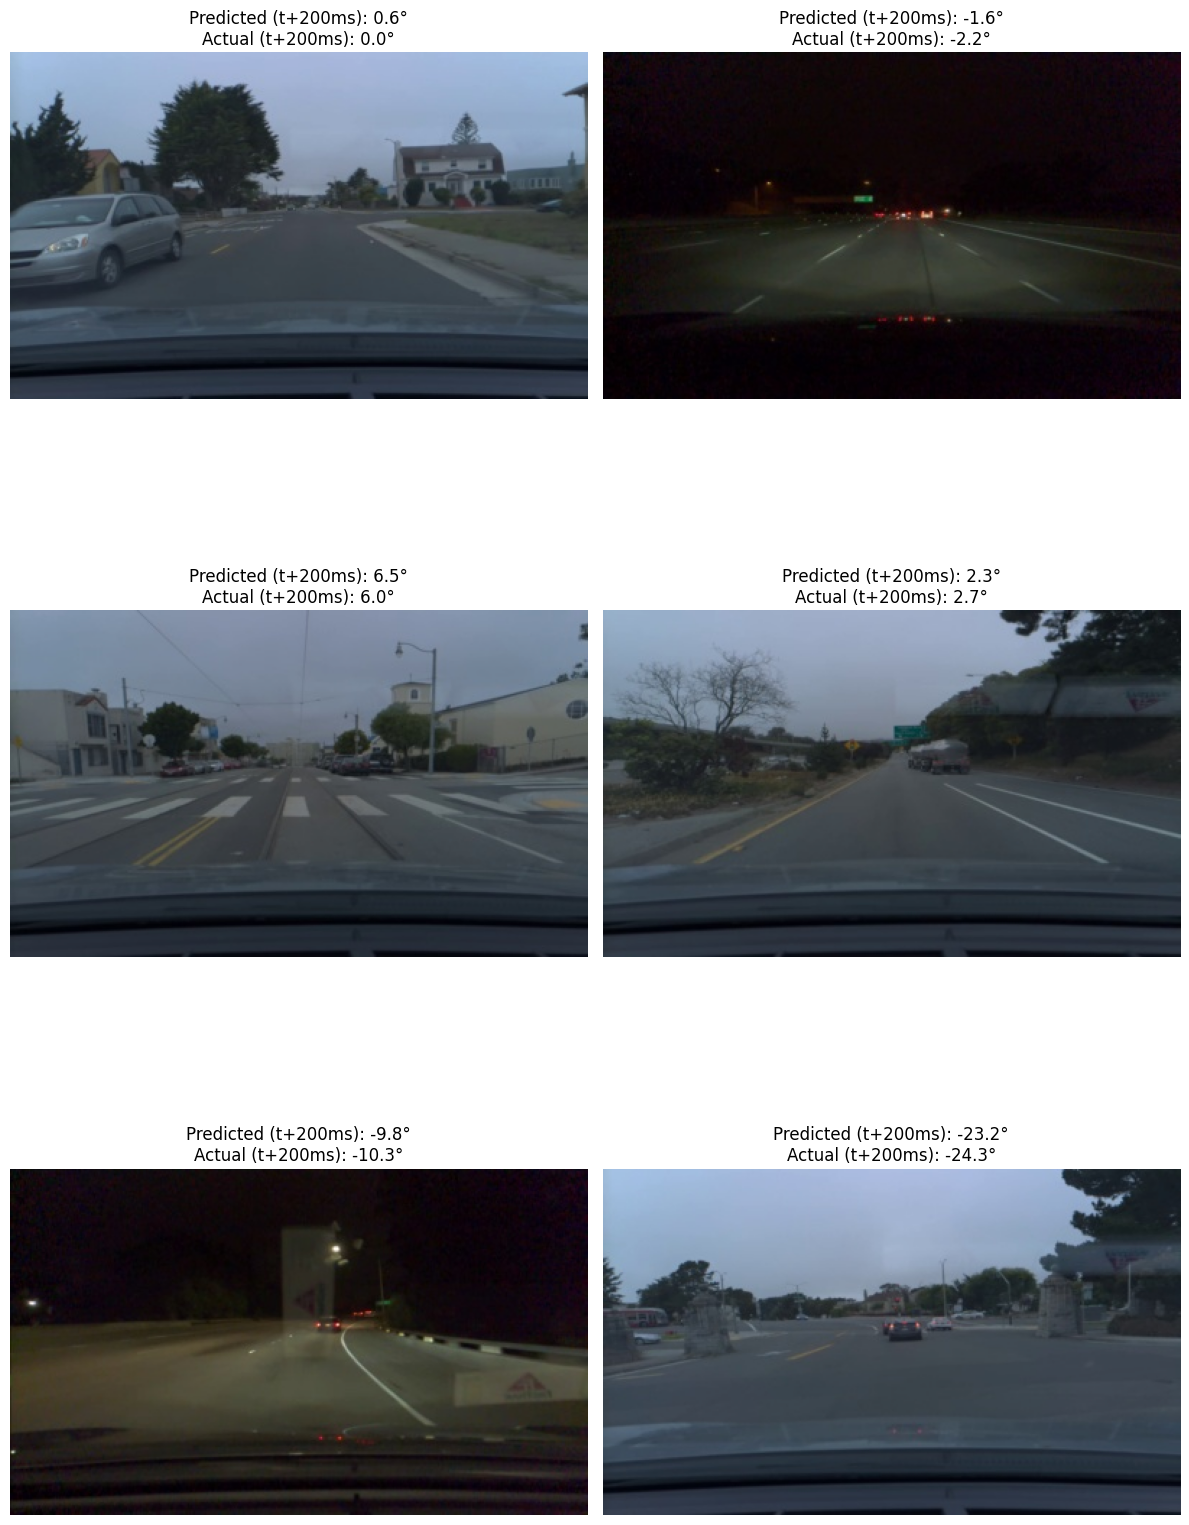

In [6]:
# Initialize model and training components
model = SteeringRNN(sequence_length=10, hidden_size=64)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Create data loaders with appropriate batch size
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# Train the model
model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=50,
    patience=8
)

# Save the trained model
torch.save(model.state_dict(), 'v4_RNN.pth')
print("\nModel saved to 'v4_RNN.pth'")

# Test the model
print("\nTesting the model...")
test_model(model, test_loader)

def visualize_sequence_predictions(model, test_loader):
    model.eval()
    device = next(model.parameters()).device

    # Get a single batch
    image_sequence, sensor_sequence, target_sequence = next(iter(test_loader))
    image_sequence = image_sequence.to(device)
    sensor_sequence = sensor_sequence.to(device)

    with torch.no_grad():
        predictions = model(image_sequence, sensor_sequence)

    # Convert to numpy for visualization
    predictions = predictions.cpu().numpy()
    targets = target_sequence.numpy()

    # Plot a few examples
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))
    for i in range(min(6, len(predictions))):
        ax = axes[i//2, i%2]

        # Get the last frame of the sequence
        img = image_sequence[i, -1].cpu().numpy().transpose(1, 2, 0)

        # Denormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(f'Predicted (t+200ms): {predictions[i, -1, 0]:.1f}°\nActual (t+200ms): {targets[i, -1]:.1f}°')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizing some predictions...")
visualize_sequence_predictions(model, test_loader)